In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.utils import all_estimators
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [83]:
df = pd.read_csv('final_datasets/enhanced_anxiety_dataset.csv')
# df = pd.read_csv('cleaned_enhanced_anxiety_dataset.csv')
target_column = 'Anxiety Level (1-10)'
df[target_column] = df[target_column].astype('object')

print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])
print("Target column:", target_column)

Total rows: 11000
Total columns: 19
Target column: Anxiety Level (1-10)


In [84]:
df.head()

,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                11000 non-null  int64  
 1   Gender                             11000 non-null  object 
 2   Occupation                         11000 non-null  object 
 3   Sleep Hours                        11000 non-null  float64
 4   Physical Activity (hrs/week)       11000 non-null  float64
 5   Caffeine Intake (mg/day)           11000 non-null  int64  
 6   Alcohol Consumption (drinks/week)  11000 non-null  int64  
 7   Smoking                            11000 non-null  object 
 8   Family History of Anxiety          11000 non-null  object 
 9   Stress Level (1-10)                11000 non-null  int64  
 10  Heart Rate (bpm)                   11000 non-null  int64  
 11  Breathing Rate (breaths/min)       11000 non-null  int

In [86]:
df.isnull().sum()

Age                                  0
Gender                               0
Occupation                           0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64

In [87]:
def unic_columns(data):
    object_columns = data.select_dtypes(include='object').columns
    for column in object_columns:
        print(f"Унікальні значення в колонці: '{column}' : ")
        print(data[column].value_counts())
        print("-" * 50)

unic_columns(df)

Унікальні значення в колонці: 'Gender' : 
Gender
Female    3730
Male      3657
Other     3613
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Occupation' : 
Occupation
Musician      892
Artist        888
Student       878
Nurse         861
Chef          858
Doctor        842
Other         840
Freelancer    838
Engineer      833
Scientist     832
Athlete       822
Lawyer        809
Teacher       807
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Smoking' : 
Smoking
Yes    5779
No     5221
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Family History of Anxiety' : 
Family History of Anxiety
Yes    5847
No     5153
Name: count, dtype: int64
--------------------------------------------------
Унікальні значення в колонці: 'Dizziness' : 
Dizziness
Yes    5672
No     5328
Name: count, dtype: int64
----------------

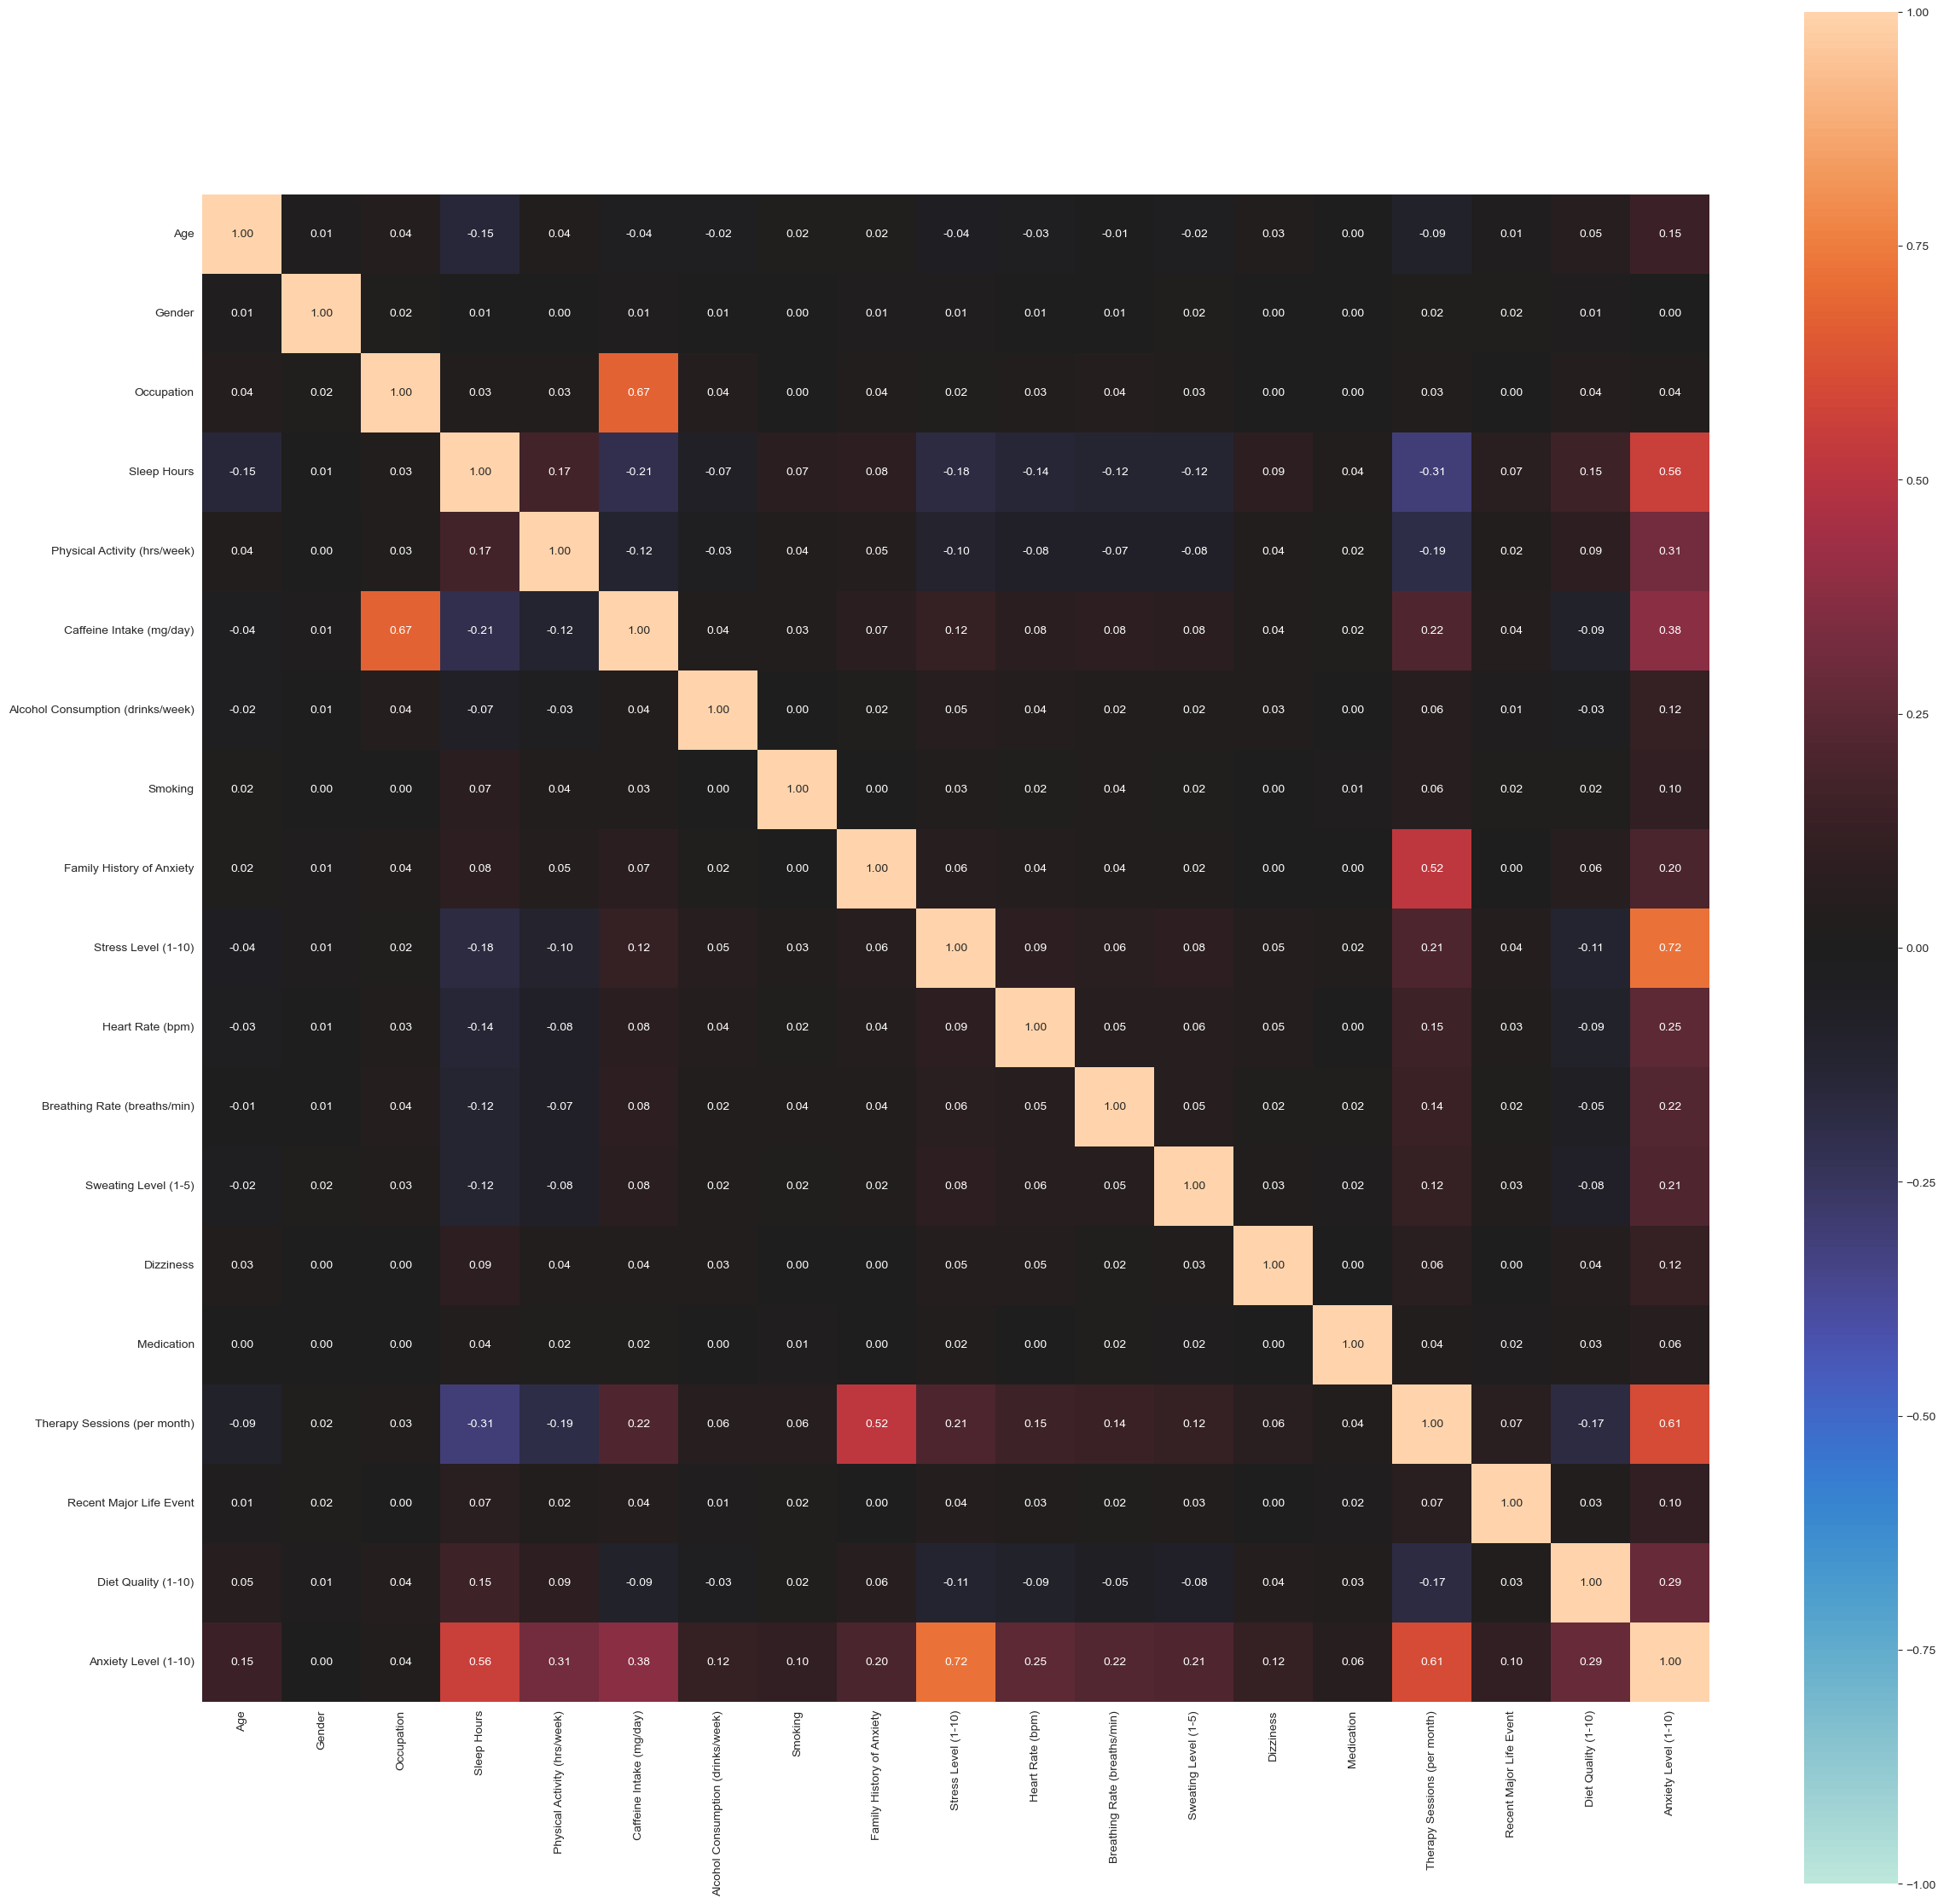

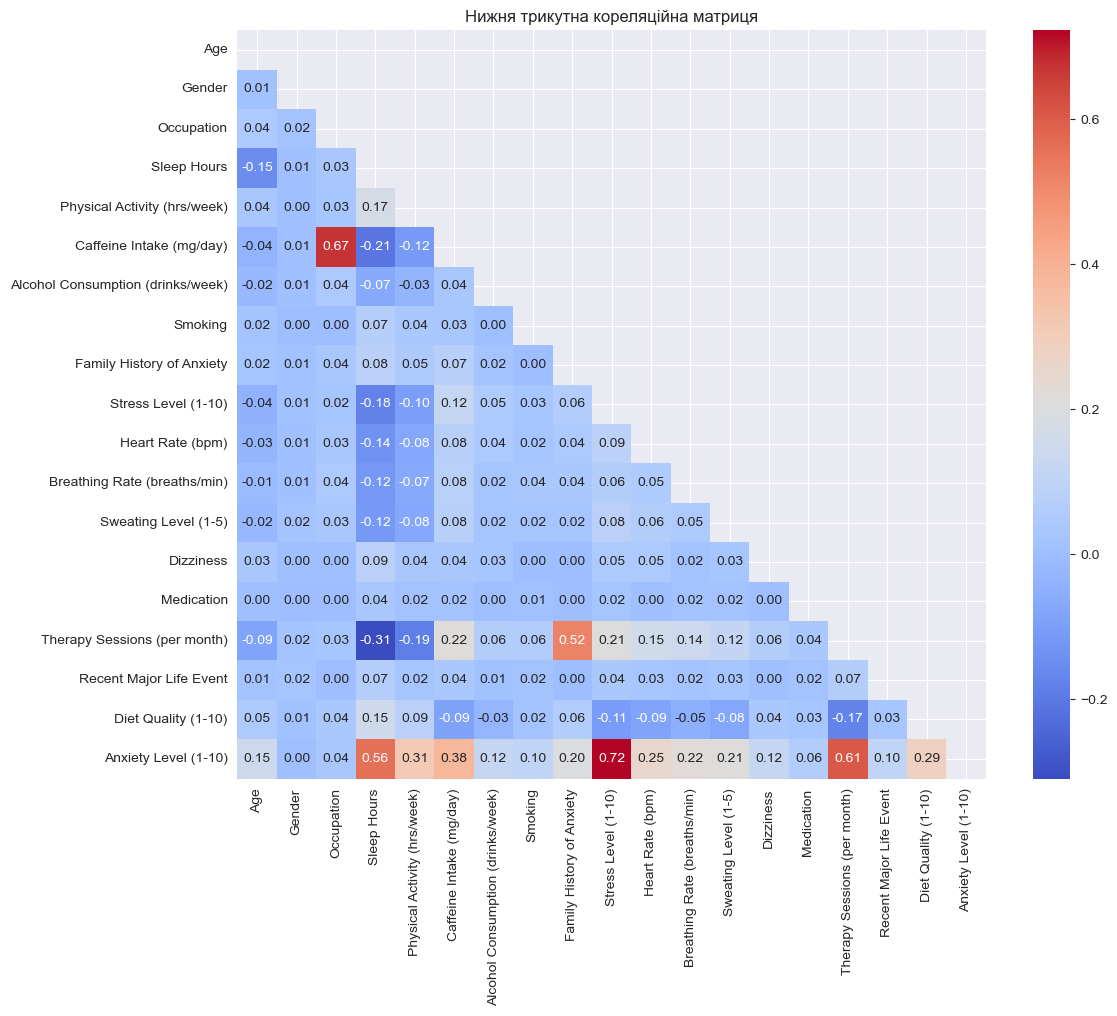


Висококорельовані пари ознак:

Коефіцієнт кореляції відносно цільового поля Anxiety Level (1-10)
                                   Correlations
Anxiety Level (1-10)                   1.000000
Stress Level (1-10)                    0.722448
Therapy Sessions (per month)           0.607668
Sleep Hours                            0.557664
Caffeine Intake (mg/day)               0.380886
Physical Activity (hrs/week)           0.313165
Diet Quality (1-10)                    0.288977
Heart Rate (bpm)                       0.253507
Breathing Rate (breaths/min)           0.219793
Sweating Level (1-5)                   0.213856
Family History of Anxiety              0.195934
Age                                    0.145686
Dizziness                              0.121375
Alcohol Consumption (drinks/week)      0.121077
Smoking                                0.104605
Recent Major Life Event                0.103318
Medication                             0.061205
Occupation                            

In [88]:
def corr_dif(data, threshold=0.85):
    correlation_matrix = associations(data)
    
    def plot_lower_triangle_corr_matrix(corr_matrix):
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        plt.figure(figsize=(12, 10))  
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True)
        plt.title("Нижня трикутна кореляційна матриця")
        plt.tight_layout()
        plt.show()
        
    plot_lower_triangle_corr_matrix(correlation_matrix['corr'])
    
    def get_highly_correlated_pairs(corr_matrix, threshold=0.85):
        corr_pairs = []
        cols = corr_matrix.columns
        for i in range(len(cols)):
            for j in range(i):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) >= threshold:
                    corr_pairs.append((cols[i], cols[j], corr_value))
        return sorted(corr_pairs, key=lambda x: -abs(x[2]))
    
    highly_correlated_pairs = get_highly_correlated_pairs(correlation_matrix['corr'], threshold)
    
    print("\nВисококорельовані пари ознак:")
    for col1, col2, value in highly_correlated_pairs:
        print(f"{col1} - {col2} --> кореляція {value:.2f}")
        
    target_correlations = correlation_matrix['corr'].iloc[:, -1]
    target_col = target_correlations.name
    
    corr_df = target_correlations.to_frame()
    corr_df.columns = ['Correlations']
    corr_df['Abs Correlation'] = corr_df['Correlations'].abs()
    sorted_corr_df = corr_df.sort_values(by='Abs Correlation', ascending=False)
    sorted_corr_df = sorted_corr_df.drop(columns=['Abs Correlation'])
    print(f"\nКоефіцієнт кореляції відносно цільового поля {target_col}")
    pd.set_option('display.max_rows', None)
    print(sorted_corr_df)
    
    return correlation_matrix

correlation_result = corr_dif(df, 0.8)

In [89]:
df_2 = df.copy()

In [90]:
target_original = 'Anxiety Level (1-10)'
def categorize_anxiety(level):
    level = int(level) if isinstance(level, str) else level
    if level <= 4:
        return 'Low'
    elif 4 < level <= 7:
        return 'Medium'
    else: 
        return 'High'

df['Anxiety Class'] = df[target_original].apply(categorize_anxiety).astype('category')
df.to_csv('new.csv', index=False)
target_col = 'Anxiety Class'
df = df.drop(columns=[target_original])

numeric_cols = df.select_dtypes(include='number').columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if target_col in categorical_cols:
    categorical_cols.remove(target_col)

print(f"Числові колонки ({len(numeric_cols)}): {numeric_cols}")
print(f"Категоріальні колонки ({len(categorical_cols)}): {categorical_cols}")
print(f"Цільова змінна: {target_col}")

Числові колонки (11): ['Age', 'Sleep Hours', 'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)', 'Alcohol Consumption (drinks/week)', 'Stress Level (1-10)', 'Heart Rate (bpm)', 'Breathing Rate (breaths/min)', 'Sweating Level (1-5)', 'Therapy Sessions (per month)', 'Diet Quality (1-10)']
Категоріальні колонки (7): ['Gender', 'Occupation', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']
Цільова змінна: Anxiety Class


створюжм 3 датасети на кожен клас і в них визначаємо аутлаєри (95% варіансу має пояснення) і за допомогою Isolation forest видаляємо аутлаєри, далі цих три датасети конкатенуємо назад в один, також візуалізувати три кластери з цими класами

In [91]:
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"Закодовано {col}: {len(le.classes_)} унікальних значень")

le_y = LabelEncoder()
y = le_y.fit_transform(df[target_col])
print(f"\nКласи цільової змінної: {le_y.classes_}")
print(f"Розподіл класів: {np.bincount(y)}")

Закодовано Gender: 3 унікальних значень
Закодовано Occupation: 13 унікальних значень
Закодовано Smoking: 2 унікальних значень
Закодовано Family History of Anxiety: 2 унікальних значень
Закодовано Dizziness: 2 унікальних значень
Закодовано Medication: 2 унікальних значень
Закодовано Recent Major Life Event: 2 унікальних значень

Класи цільової змінної: ['High' 'Low' 'Medium']
Розподіл класів: [1014 7618 2368]


In [92]:
# scaler = StandardScaler()
# df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
# 
# print("Масштабування числових ознак завершено")
# print(f"Середнє значення після масштабування:\n{df_encoded[numeric_cols].mean()}")
# print(f"\nСтандартне відхилення після масштабування:\n{df_encoded[numeric_cols].std()}")

In [93]:
# # from sklearn.ensemble import IsolationForest
# # 
# # df_cleaned_list = []
# # contamination_rate = 0.05
# # 
# # for class_label in np.unique(y):
# #     class_mask = (y == class_label)
# #     X_class = df_encoded.drop(columns=[target_col])[class_mask]
# #     y_class = y[class_mask]
# #     
# #     iso = IsolationForest(contamination=contamination_rate, random_state=42)
# #     outlier_preds = iso.fit_predict(X_class)
# #     
# #     X_class_cleaned = X_class[outlier_preds == 1]
# #     y_class_cleaned = y_class[outlier_preds == 1]
# #     
# #     temp_df = X_class_cleaned.copy()
# #     temp_df[target_col] = y_class_cleaned
# #     df_cleaned_list.append(temp_df)
# #     
# #     print(f"Клас '{le_y.classes_[class_label]}': видалено {sum(outlier_preds == -1)} аутлаєрів")
# # 
# # df_final_cleaned = pd.concat(df_cleaned_list, axis=0).sample(frac=1, random_state=42)
# # df_final_cleaned.to_csv('final_cleaned.csv', index=False)
# # X = df_final_cleaned.drop(columns=[target_col])
# # y = df_final_cleaned[target_col].values
# # from imblearn.under_sampling import EditedNearestNeighbors
# # X_full = df_encoded.drop(columns=[target_col])
# # y_full = y # використовуємо вже закодований y
# 
# # print(f"Початкова кількість записів: {len(X_full)}")
# 
# # 2. Використовуємо алгоритм сімейства Nearest Neighbors для видалення аутлаєрів
# # EditedNearestNeighbors видаляє зразки, чий клас відрізняється від більшості сусідів.
# # Це ідеально підходить для очищення "шуму" та аутлаєрів на межах.
# # enn = EditedNearestNeighbors(n_neighbors=3)
# # X_resampled, y_resampled = enn.fit_resample(X_full, y_full)
# 
# # Оскільки ENN видаляє стільки, скільки вважає за потрібне, перевіримо результат
# # print(f"Кількість записів після ENN: {len(X_resampled)}")
# # print(f"Видалено всього: {len(X_full) - len(X_resampled)} рядків")
# 
# # 3. Якщо вам потрібно видалити СТРОГО 5% (як ви просили раніше)
# # Nearest Neighbors не гарантує фіксований відсоток, але він набагато точніше 
# # знаходить аномалії в ненормальному розподілі, ніж статистичні методи.
# 
# # 4. Формуємо фінальний очищений датасет
# # df_final_cleaned = X_resampled.copy()
# # df_final_cleaned[target_col] = y_resampled
# # 
# # # Перемішуємо дані
# # df_final_cleaned = df_final_cleaned.sample(frac=1, random_state=42)
# # 
# # # Оновлюємо змінні для навчання
# # X = df_final_cleaned.drop(columns=[target_col])
# # y = df_final_cleaned[target_col].values
# # X = df_encoded.drop(columns=[target_col])
# 
# from sklearn.neighbors import NearestNeighbors
# 
# # 1. Підготовка даних
# X_full = df_encoded.drop(columns=[target_col])
# y_full = y
# 
# # 2. Реалізація логіки Edited Nearest Neighbors (ENN) вручну
# # Ми видаляємо точки, чий клас не збігається з більшістю з 3-х найближчих сусідів
# n_neighbors = 3
# nn = NearestNeighbors(n_neighbors=n_neighbors + 1) # +1, бо точка є сусідом сама собі
# nn.fit(X_full)
# 
# # Знаходимо індекси сусідів для кожної точки
# distances, indices = nn.kneighbors(X_full)
# 
# # Маска для тих, кого ми залишимо
# keep_mask = []
# 
# for i in range(len(X_full)):
#     # Індекси сусідів (пропускаємо перший індекс, бо це сама точка)
#     neighbor_indices = indices[i][1:]
#     # Класи сусідів
#     neighbor_classes = y_full[neighbor_indices]
#     
#     # Якщо клас точки збігається з більшістю сусідів - залишаємо
#     # (Наприклад, якщо хоча б 2 з 3 сусідів мають такий самий клас)
#     most_common_neighbor_class = np.bincount(neighbor_classes).argmax()
#     
#     if y_full[i] == most_common_neighbor_class:
#         keep_mask.append(True)
#     else:
#         keep_mask.append(False)
# 
# keep_mask = np.array(keep_mask)
# 
# # 3. Формуємо очищений датасет
# X_resampled = X_full[keep_mask]
# y_resampled = y_full[keep_mask]
# 
# print(f"Початкова кількість записів: {len(X_full)}")
# print(f"Видалено 'шумних' точок (NN-outliers): {len(X_full) - len(X_resampled)}")
# 
# df_final_cleaned = X_resampled.copy()
# df_final_cleaned[target_col] = y_resampled
# df_final_cleaned[target_col] = le_y.inverse_transform(df_final_cleaned[target_col])
# df_final_cleaned = df_final_cleaned.sample(frac=1, random_state=42)
# df_final_cleaned.to_csv('anxiety_dataset_enn.csv')
# # Оновлюємо змінні для подальшого коду
# X = df_final_cleaned.drop(columns=[target_col])
# y = df_final_cleaned[target_col].values
# n_classes = len(np.unique(y))
# is_multiclass = n_classes > 2
# 
# print(f"Кількість класів: {n_classes}")
# print(f"Мультикласова класифікація: {is_multiclass}")
# 
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )
# 
# print(f"\nРозмір тренувальної вибірки: {X_train.shape}")
# print(f"Розмір тестової вибірки: {X_test.shape}")
# # print(f"Розподіл класів у тренувальній вибірці: {np.bincount(y_train)}")
# # print(f"Розподіл класів у тестовій вибірці: {np.bincount(y_test)}")